#Imports and Variables Value Initializer

In [1]:
!pip install Sastrawi

     |████████████████████████████████| 215kB 6.9MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
vocab_size = 20000
embedding_dim = 100
max_length = 50
trunc_type = 'post'
oov_tok = "<OOV>"

In [ ]:
'''
Project: Bangkit Capstone Project
Group: B21-CAP0194
Part: Modelling
'''

'\nProject: Bangkit Capstone Project\nGroup: B21-CAP0194\nPart: Modelling\n'

#Translate the Dataset (Post)

In [ ]:
#Import Labelled Post Dataset
url_post = 'https://drive.google.com/file/d/1VPg3UmXkT0cGEIbifhoiI4JKz3M7NX-w/view?usp=sharing'
file_id_post = url_post.split('/')[-2]
csv_url_post = 'https://drive.google.com/uc?id=' + file_id_post
df_post = pd.read_csv(csv_url_post)
df_post.head()

,text,label,index
0,the ironies of the movement are too painfully ...,Lokasi Kerja,0
1,women in kuwait have launched a social media c...,Siber,1
2,triger warning raising awareness of sexual ass...,Lokasi Privat,2
3,charges brought against the guy that smacked m...,Lokasi Privat,3
4,and the fourth presenter on th may is hannah b...,Lokasi Pendidikan,4


In [ ]:
#Warning! It's not free, please think several times before running this cell below
#Enter the API Key
import getpass

APIKEY = getpass.getpass()

··········


In [ ]:
#Warning! It's also not free, please think several times before running this cell below
#Running Translate API
from googleapiclient.discovery import build
service = build('translate', 'v2', developerKey=APIKEY)

df_post['indo_text'] = df_post['text'].apply(lambda x: (service.translations().list(source='en', target='id', q=x).execute())).apply(lambda x: x['translations']).apply(lambda x: x[0]).apply(lambda x: x['translatedText'])

In [ ]:
#Show the first 50 data in the dataset
df_post['indo_text'].head(50)

0     ironi gerakan ini terlalu menyakitkan jelas di...
1     wanita di kuwait telah meluncurkan kampanye me...
2     peringatan triger meningkatkan kesadaran akan ...
3     dakwaan yang diajukan terhadap pria yang memuk...
4     dan presenter keempat pada bulan Mei adalah ma...
5     Ini sangat kacau, adakah pria di mata publik, ...
6     untuk mengatasi epidemi kekerasan laki-laki te...
7     Ada serangkaian tuduhan pelecehan baru terhada...
8     ingin melihat seperti apa gerakan para wanita ...
9     siswa perempuan tidak ingin berhubungan seks d...
10    ketika kita berbicara tentang dan kekerasan, k...
11    mengambil jutaan tahun lalu dalam dana nih nih...
12    bantu siswa Anda untuk memerangi pelecehan den...
13    Saya masih ingin berbicara dengan wanita penya...
14    glenn greenwald tidak suka gerakan mendukung m...
15    untuk lebih lanjut tentang topik ini bergabung...
16    apa hubungan gerakan itu dengan pembunuhan ma ...
17    opini terbaru dari dan cuomo membutuhkan w

In [ ]:
#Convert the text into lowercase
df_post['indo_text'] = df_post['indo_text'].str.lower()

In [ ]:
#Save DataFrame to CSV
df_post.to_csv("capstonetweetposttranslated.csv", index=False)

#Applying Stopwords and Stemmer (Post)

In [ ]:
#Import Translated Post Dataset
url_post = 'https://drive.google.com/file/d/1dWQB76NUK2DsPSYvxPD2KJQ12bKM7hmA/view?usp=sharing'
file_id_post = url_post.split('/')[-2]
csv_url_post = 'https://drive.google.com/uc?id=' + file_id_post
df_post = pd.read_csv(csv_url_post)
df_post.head()

,text,label,index,indo_text
0,the ironies of the movement are too painfully ...,Lokasi Kerja,0,ironi gerakan ini terlalu menyakitkan jelas di...
1,women in kuwait have launched a social media c...,Siber,1,wanita di kuwait telah meluncurkan kampanye me...
2,triger warning raising awareness of sexual ass...,Lokasi Privat,2,peringatan triger meningkatkan kesadaran akan ...
3,charges brought against the guy that smacked m...,Lokasi Privat,3,dakwaan yang diajukan terhadap pria yang memuk...
4,and the fourth presenter on th may is hannah b...,Lokasi Pendidikan,4,dan presenter keempat pada bulan mei adalah ma...


In [ ]:
df_post['text'] = df_post['indo_text']
df_post = df_post.drop(['indo_text'], axis=1)

In [ ]:
df_post['text']

0        ironi gerakan ini terlalu menyakitkan jelas di...
1        wanita di kuwait telah meluncurkan kampanye me...
2        peringatan triger meningkatkan kesadaran akan ...
3        dakwaan yang diajukan terhadap pria yang memuk...
4        dan presenter keempat pada bulan mei adalah ma...
                               ...                        
17498    ini adalah pasar dosen muda yang mungkin anda ...
17499    dosen redpath menginap di hotel anak muda dan ...
17500    ada dosen yang membahas berbagai topik dari me...
17501    mereka menggantikan pemikiran dan sangat bergu...
17502    vizard, seorang konsultan independen yang mela...
Name: text, Length: 17503, dtype: object

In [ ]:
#Remove Stopwords from Texts
stopwordFactory = StopWordRemoverFactory()
stopword = stopwordFactory.create_stop_word_remover()

df_post['text'] = df_post['text'].apply(lambda x: stopword.remove(x))

In [ ]:
df_post['text']

0        ironi gerakan terlalu menyakitkan jelas dipelo...
1        wanita kuwait meluncurkan kampanye media sosia...
2        peringatan triger meningkatkan kesadaran pelec...
3        dakwaan diajukan pria memukul serangan seksual...
4        presenter keempat bulan mei mahasiswa phd hann...
                               ...                        
17498    adalah pasar dosen muda mungkin hargai sini se...
17499    dosen redpath menginap hotel anak muda menghab...
17500    dosen membahas berbagai topik mendelisme hingg...
17501    menggantikan pemikiran sangat berguna para opt...
17502    vizard, seorang konsultan independen melatih d...
Name: text, Length: 17503, dtype: object

In [ ]:
#Stem the Texts (Removing Prefix and Suffix)
stemmerFactory = StemmerFactory()
stemmer = stemmerFactory.create_stemmer()

df_post['text'] = df_post['text'].apply(lambda x: stemmer.stem(x))

In [ ]:
df_post['text']

0        ironi gera terlalu sakit jelas lopor aktris ho...
1        wanita kuwait luncur kampanye media sosial man...
2        ingat triger tingkat sadar leceh seksual keras...
3        dakwa aju pria pukul serang seksual persetan b...
4        presenter empat bulan mei mahasiswa phd hannah...
                               ...                        
17498    adalah pasar dosen muda mungkin harga sini sem...
17499    dosen redpath inap hotel anak muda habis hari ...
17500    dosen bahas bagai topik mendelisme hingga meso...
17501           ganti pikir sangat guna para optimis dosen
17502    vizard orang konsultan independen latih dosen ...
Name: text, Length: 17503, dtype: object

In [ ]:
#Save DataFrame to CSV
df_post.to_csv("capstonetweetpoststemmed.csv", index=False)

#Modelling (Post)

In [108]:
#Import Stemmed Dataset
url_post = 'https://drive.google.com/file/d/1M-JOISRaxP0aPgJo_EdjPKBdHLCaSlCb/view?usp=sharing'
file_id_post = url_post.split('/')[-2]
csv_url_post = 'https://drive.google.com/uc?id=' + file_id_post
df_post = pd.read_csv(csv_url_post)
df_post.head()

,text,label,index
0,ironi gera terlalu sakit jelas lopor aktris ho...,Lokasi Kerja,0
1,wanita kuwait luncur kampanye media sosial man...,Siber,1
2,ingat triger tingkat sadar leceh seksual keras...,Lokasi Privat,2
3,dakwa aju pria pukul serang seksual persetan b...,Lokasi Privat,3
4,presenter empat bulan mei mahasiswa phd hannah...,Lokasi Pendidikan,4


In [109]:
df_post['text']

0        ironi gera terlalu sakit jelas lopor aktris ho...
1        wanita kuwait luncur kampanye media sosial man...
2        ingat triger tingkat sadar leceh seksual keras...
3        dakwa aju pria pukul serang seksual persetan b...
4        presenter empat bulan mei mahasiswa phd hannah...
                               ...                        
17498    adalah pasar dosen muda mungkin harga sini sem...
17499    dosen redpath inap hotel anak muda habis hari ...
17500    dosen bahas bagai topik mendelisme hingga meso...
17501           ganti pikir sangat guna para optimis dosen
17502    vizard orang konsultan independen latih dosen ...
Name: text, Length: 17503, dtype: object

In [110]:
df_post['label'].value_counts()

Netral               4617
Lokasi Publik        3679
Lokasi Privat        3109
Siber                2313
Lokasi Kerja         1894
Lokasi Pendidikan    1891
Name: label, dtype: int64

In [111]:
labels = pd.get_dummies(df_post.label)

In [112]:
df_new_post = pd.concat([df_post, labels], axis=1)

In [113]:
df_new_post.head()

,text,label,index,Lokasi Kerja,Lokasi Pendidikan,Lokasi Privat,Lokasi Publik,Netral,Siber
0,ironi gera terlalu sakit jelas lopor aktris ho...,Lokasi Kerja,0,1,0,0,0,0,0
1,wanita kuwait luncur kampanye media sosial man...,Siber,1,0,0,0,0,0,1
2,ingat triger tingkat sadar leceh seksual keras...,Lokasi Privat,2,0,0,1,0,0,0
3,dakwa aju pria pukul serang seksual persetan b...,Lokasi Privat,3,0,0,1,0,0,0
4,presenter empat bulan mei mahasiswa phd hannah...,Lokasi Pendidikan,4,0,1,0,0,0,0


In [114]:
tweet_post = df_new_post['text'].astype(str).values
label_post = df_new_post[["Lokasi Kerja", "Lokasi Pendidikan", "Lokasi Privat", "Lokasi Publik", "Netral", "Siber"]].values

In [115]:
label_post

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [116]:
from sklearn.model_selection import train_test_split
#Train Text, Test Text, Train Label, Test Label
X_train, X_test, y_train, y_test = train_test_split(tweet_post, label_post, test_size=0.2, shuffle=True)

In [117]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length)

In [118]:
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_accuracy')>0.80):
			print("Desired accuracy reached!")
			self.model.stop_training=True

In [119]:
import tensorflow as tf

#Initial Model (Base bi-lstm with 2 layer bi)
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])

'''
#First Improvement (4 layer bi-lstm with dropout)
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])
'''
'''
#Second Improvement with embedding_dim=100 (CNN-LSTM)
# val_acc = 0.7586, 0.7744
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv1D(64, 3, activation='relu',padding='same'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.MaxPooling1D(pool_size=3),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(16),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(6, activation='softmax')
])
'''
'''
#LAST MODEL MINION (Bi-LSTM - GRU)
#LAST: 0.73, BEST: 0.76
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, recurrent_dropout=0.2, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(6, activation='softmax')
])
'''

"\n#LAST MODEL MINION (Bi-LSTM - GRU)\n#LAST: 0.73, BEST: 0.76\nmodel = tf.keras.Sequential([\n  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),\n  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, recurrent_dropout=0.2, return_sequences=True)),\n  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),\n  tf.keras.layers.Dense(128, activation='relu'),\n  tf.keras.layers.Dropout(0.5),\n  tf.keras.layers.Dense(6, activation='softmax')\n])\n"

In [120]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           2000000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 50, 128)           84480     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_7 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 2,127,974
Trainable params: 2,127,974
Non-trainable params: 0
_________________________________________________________________


In [121]:
num_epochs = 10
callbacks = myCallback()
history = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[callbacks])

Epoch 1/10
438/438 [==============================] - 62s 128ms/step - loss: 1.2894 - accuracy: 0.4834 - val_loss: 1.0089 - val_accuracy: 0.6370
Epoch 2/10
438/438 [==============================] - 54s 124ms/step - loss: 0.7355 - accuracy: 0.7507 - val_loss: 0.7556 - val_accuracy: 0.7481
Epoch 3/10
438/438 [==============================] - 54s 124ms/step - loss: 0.4666 - accuracy: 0.8552 - val_loss: 0.7725 - val_accuracy: 0.7521
Epoch 4/10
438/438 [==============================] - 54s 124ms/step - loss: 0.3233 - accuracy: 0.9028 - val_loss: 0.8566 - val_accuracy: 0.7464
Epoch 5/10
438/438 [==============================] - 54s 124ms/step - loss: 0.2355 - accuracy: 0.9304 - val_loss: 0.8949 - val_accuracy: 0.7478
Epoch 6/10
438/438 [==============================] - 55s 124ms/step - loss: 0.1774 - accuracy: 0.9488 - val_loss: 1.0530 - val_accuracy: 0.7444
Epoch 7/10
438/438 [==============================] - 54s 124ms/step - loss: 0.1470 - accuracy: 0.9564 - val_loss: 1.0383 - val_ac

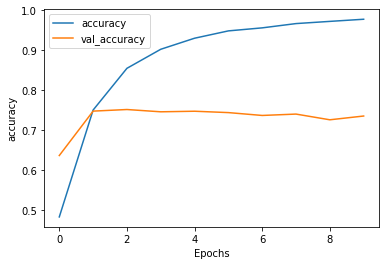

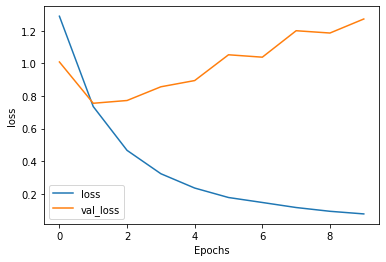

In [122]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [123]:
text = ["guru mengajar di sekolah"]

tokenized_text = tokenizer.texts_to_sequences(text)

In [124]:
prediction = model.predict(tokenized_text)

In [125]:
labels = ["Lokasi Kerja", "Lokasi Pendidikan", "Lokasi Privat", "Lokasi Publik", "Netral", "Siber"]
predicted = prediction.argmax(axis=1)
predict_labels = [labels[predict] for predict in predicted]
print(prediction)
print(predict_labels)

[[7.1406712e-06 9.9969101e-01 7.1403915e-06 1.5209675e-04 4.4028488e-06
  1.3826739e-04]]
['Lokasi Pendidikan']


In [126]:
#Exporting the Model (TFLITE)
export_dir = 'saved_model_post/1'
tf.saved_model.save(model, export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: saved_model_post/1/assets


INFO:tensorflow:Assets written to: saved_model_post/1/assets


In [127]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [128]:
import pathlib

tflite_model_post_file = pathlib.Path('/content/modelpost.tflite')
tflite_model_post_file.write_bytes(tflite_model)

8560940

In [129]:
from google.colab import files
files.download(tflite_model_post_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [130]:
#Exporting the Tokenized Word
import json

with open( 'word_dict_post.json' , 'w' ) as file:
    json.dump( tokenizer.word_index , file )

#Translate the Dataset (Laporan)

In [ ]:
#Import Labelled Laporan Dataset
url_laporan = 'https://drive.google.com/file/d/1fljXpb0LSiSelHDJLaEDt7rw0e2_ZcoY/view?usp=sharing'
file_id_laporan = url_laporan.split('/')[-2]
csv_url_laporan = 'https://drive.google.com/uc?id=' + file_id_laporan
df_laporan = pd.read_csv(csv_url_laporan)
df_laporan.head()

,text,label,index
0,the ironies of the movement are too painfully ...,Kekerasan Psikis,0
1,women in kuwait have launched a social media c...,Kekerasan Psikis,1
2,triger warning raising awareness of sexual ass...,Penelantaran,2
3,charges brought against the guy that smacked m...,Kekerasan Fisik,3
4,and the fourth presenter on th may is hannah b...,Kekerasan Lainnya,4


In [ ]:
#Warning! It's not free, please think several times before running this cell below
#Enter the API Key
import getpass

APIKEY = getpass.getpass()

··········


In [ ]:
#Warning! It's also not free, please think several times before running this cell below
#Running Translate API
from googleapiclient.discovery import build
service = build('translate', 'v2', developerKey=APIKEY)

df_laporan['indo_text'] = df_laporan['text'].apply(lambda x: (service.translations().list(source='en', target='id', q=x).execute())).apply(lambda x: x['translations']).apply(lambda x: x[0]).apply(lambda x: x['translatedText'])

In [ ]:
#Show the first 50 data in the dataset
df_laporan['indo_text'].head(50)

0     ironi gerakan ini terlalu menyakitkan dan jela...
1     wanita di kuwait telah meluncurkan kampanye me...
2     peringatan triger meningkatkan kesadaran akan ...
3     tuduhan yang diajukan terhadap pria yang memuk...
4     dan presenter keempat pada bulan Mei adalah ma...
5     Ini sangat kacau, adakah pria di mata publik, ...
6     untuk mengatasi epidemi kekerasan laki-laki te...
7     Ada serangkaian tuduhan pelecehan baru terhada...
8     ingin melihat seperti apa gerakan para wanita ...
9     siswa perempuan tidak ingin berhubungan seks d...
10    ketika kita berbicara tentang dan kekerasan, k...
11    mengambil jutaan tahun lalu di nih dana nih ma...
12    bantu siswa Anda untuk memerangi pelecehan men...
13    Saya masih ingin berbicara dengan wanita penya...
14    glenn greenwald tidak suka gerakan mendukung m...
15    untuk lebih lanjut tentang topik ini bergabung...
16    apa hubungan gerakan itu dengan pembunuhan ma ...
17    opini terbaru dari dan cuomo membutuhkan w

In [ ]:
#Convert the text into lowercase
df_laporan['indo_text'] = df_laporan['indo_text'].str.lower()

In [ ]:
#Save DataFrame to CSV
df_laporan.to_csv("capstonetweetlaporantranslated.csv", index=False)

#Applying Stopwords and Stemmer (Laporan)

In [ ]:
#Import Translated Laporan Dataset
url_laporan = 'https://drive.google.com/file/d/194Eo3N7FpEZBAHooCB7alzKQg_hvn31p/view?usp=sharing'
file_id_laporan = url_laporan.split('/')[-2]
csv_url_laporan = 'https://drive.google.com/uc?id=' + file_id_laporan
df_laporan = pd.read_csv(csv_url_laporan)
df_laporan.head()

,text,label,index,indo_text
0,the ironies of the movement are too painfully ...,Kekerasan Psikis,0,ironi gerakan ini terlalu menyakitkan dan jela...
1,women in kuwait have launched a social media c...,Kekerasan Psikis,1,wanita di kuwait telah meluncurkan kampanye me...
2,triger warning raising awareness of sexual ass...,Penelantaran,2,peringatan triger meningkatkan kesadaran akan ...
3,charges brought against the guy that smacked m...,Kekerasan Fisik,3,tuduhan yang diajukan terhadap pria yang memuk...
4,and the fourth presenter on th may is hannah b...,Kekerasan Lainnya,4,dan presenter keempat pada bulan mei adalah ma...


In [ ]:
df_laporan['text'] = df_laporan['indo_text']
df_laporan = df_laporan.drop(['indo_text'], axis=1)

In [ ]:
df_laporan['text']

0        ironi gerakan ini terlalu menyakitkan dan jela...
1        wanita di kuwait telah meluncurkan kampanye me...
2        peringatan triger meningkatkan kesadaran akan ...
3        tuduhan yang diajukan terhadap pria yang memuk...
4        dan presenter keempat pada bulan mei adalah ma...
                               ...                        
17235    tidak semuanya termasuk dalam kategori fiksi e...
17236    sheriff telah kalah dalam gugatan terhadap cra...
17237    saya menemukan puisi itu sangat ekspresif dari...
17238    frustrasi para judas diimbangi dengan devosi e...
17239    jelas bahwa hanya ada satu arah yang dia ingin...
Name: text, Length: 17240, dtype: object

In [ ]:
#Remove Stopwords from Texts
stopwordFactory = StopWordRemoverFactory()
stopword = stopwordFactory.create_stop_word_remover()

df_laporan['text'] = df_laporan['text'].apply(lambda x: stopword.remove(x))

In [ ]:
df_laporan['text']

0        ironi gerakan terlalu menyakitkan jelas dipelo...
1        wanita kuwait meluncurkan kampanye media sosia...
2        peringatan triger meningkatkan kesadaran pelec...
3        tuduhan diajukan pria memukul serangan seksual...
4        presenter keempat bulan mei mahasiswi phd hann...
                               ...                        
17235    semuanya termasuk kategori fiksi erotis, beber...
17236    sheriff kalah gugatan craigslist atas iklan la...
17237    menemukan puisi sangat ekspresif cinta romanti...
17238    frustrasi judas diimbangi devosi erotis mary m...
17239    jelas hanya satu arah dia inginkan pertemuan d...
Name: text, Length: 17240, dtype: object

In [ ]:
#Stem the Texts (Removing Prefix and Suffix)
stemmerFactory = StemmerFactory()
stemmer = stemmerFactory.create_stemmer()

df_laporan['text'] = df_laporan['text'].apply(lambda x: stemmer.stem(x))

In [ ]:
df_laporan['text']

0        ironi gera terlalu sakit jelas lopor aktris ho...
1        wanita kuwait luncur kampanye media sosial man...
2        ingat triger tingkat sadar leceh seksual keras...
3        tuduh aju pria pukul serang seksual persetan b...
4        presenter empat bulan mei mahasiswi phd hannah...
                               ...                        
17235    semua masuk kategori fiksi erotis beberapa ant...
17236    sheriff kalah gugat craigslist atas iklan laya...
17237    temu puisi sangat ekspresif cinta romantis erotis
17238    frustrasi judas imbang devosi erotis mary magd...
17239    jelas hanya satu arah dia ingin temu dan adala...
Name: text, Length: 17240, dtype: object

In [ ]:
#Save DataFrame to CSV
df_laporan.to_csv("capstonetweetlaporanstemmed.csv", index=False)

#Modelling (Laporan)

In [ ]:
#Import Stemmed Dataset
url_laporan = 'https://drive.google.com/file/d/1vEe7adAbdc7LDmq7QVsLxhDgPu3nfnuU/view?usp=sharing'
file_id_laporan = url_laporan.split('/')[-2]
csv_url_laporan = 'https://drive.google.com/uc?id=' + file_id_laporan
df_laporan = pd.read_csv(csv_url_laporan)
df_laporan.head()

,text,label,index
0,ironi gera terlalu sakit jelas lopor aktris ho...,Kekerasan Psikis,0
1,wanita kuwait luncur kampanye media sosial man...,Kekerasan Psikis,1
2,ingat triger tingkat sadar leceh seksual keras...,Penelantaran,2
3,tuduh aju pria pukul serang seksual persetan b...,Kekerasan Fisik,3
4,presenter empat bulan mei mahasiswi phd hannah...,Kekerasan Lainnya,4


In [ ]:
df_laporan['text']

4        presenter empat bulan mei mahasiswi phd hannah...
5        sangat kacau ada pria mata publik pesepakbola ...
8        lihat apa gera wanita satu dukung satu sama un...
15       lebih lanjut topik gabung diskusi simposium ka...
16       apa hubung gera dengan bunuh ma khia bryant ta...
                               ...                        
17235    semua masuk kategori fiksi erotis beberapa ant...
17236    sheriff kalah gugat craigslist atas iklan laya...
17237    temu puisi sangat ekspresif cinta romantis erotis
17238    frustrasi judas imbang devosi erotis mary magd...
17239    jelas hanya satu arah dia ingin temu dan adala...
Name: text, Length: 10927, dtype: object

In [ ]:
df_laporan['label'].value_counts()

Kekerasan Lainnya      2000
Kekerasan Fisik        1922
Kekerasan Seksual      1864
Kekerasan Psikis       1800
Eksploitasi Seksual    1295
Penelantaran           1135
Eksploitasi             911
Name: label, dtype: int64

In [ ]:
labels = pd.get_dummies(df_laporan.label)

In [ ]:
df_new_laporan = pd.concat([df_laporan, labels], axis=1)

In [ ]:
df_new_laporan.head()

,text,label,index,Eksploitasi,Eksploitasi Seksual,Kekerasan Fisik,Kekerasan Lainnya,Kekerasan Psikis,Kekerasan Seksual,Penelantaran
4,presenter empat bulan mei mahasiswi phd hannah...,Kekerasan Lainnya,4,0,0,0,1,0,0,0
5,sangat kacau ada pria mata publik pesepakbola ...,Kekerasan Lainnya,5,0,0,0,1,0,0,0
8,lihat apa gera wanita satu dukung satu sama un...,Kekerasan Lainnya,8,0,0,0,1,0,0,0
15,lebih lanjut topik gabung diskusi simposium ka...,Kekerasan Lainnya,15,0,0,0,1,0,0,0
16,apa hubung gera dengan bunuh ma khia bryant ta...,Kekerasan Lainnya,16,0,0,0,1,0,0,0


In [ ]:
tweet_laporan = df_new_laporan['text'].astype(str).values
label_laporan = df_new_laporan[["Eksploitasi", "Eksploitasi Seksual", "Kekerasan Fisik", "Kekerasan Lainnya", "Kekerasan Psikis", "Kekerasan Seksual", "Penelantaran"]].values

In [ ]:
label_laporan

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
from sklearn.model_selection import train_test_split
#Train Text, Test Text, Train Label, Test Label
X_train, X_test, y_train, y_test = train_test_split(tweet_laporan, label_laporan, test_size=0.2, shuffle=True)

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length)

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if(logs.get('val_accuracy')>0.80):
			print("Desired accuracy reached!")
			self.model.stop_training=True

In [ ]:
import tensorflow as tf
'''
#Initial Model (Base bi-lstm with 2 layer bi)
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])
'''
'''
#First Improvement (4 layer bi-lstm with dropout)
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(6, activation='softmax')
])
'''
'''
#Second Improvement with embedding_dim=100 (CNN-LSTM)
# val_acc = 0.7586, 0.7744
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Conv1D(64, 3, activation='relu',padding='same'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.MaxPooling1D(pool_size=3),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.LSTM(16),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(6, activation='softmax')
])
'''

#LAST MODEL MINION (Bi-LSTM - GRU)
#LAST: 0.73, BEST: 0.76
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, recurrent_dropout=0.2, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(6, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 32)           640000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 16)           1040      
_________________________________________________________________
dropout_16 (Dropout)         (None, 100, 16)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 33, 16)            0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 33, 16)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_18 (Dropout)         (None, 16)               

In [ ]:
num_epochs = 20
callbacks = myCallback()
history = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test), callbacks=[callbacks])

Epoch 1/10
274/274 [==============================] - 9s 26ms/step - loss: 1.9237 - accuracy: 0.1777 - val_loss: 1.8400 - val_accuracy: 0.3733
Epoch 2/10
274/274 [==============================] - 7s 24ms/step - loss: 1.7622 - accuracy: 0.3258 - val_loss: 1.5145 - val_accuracy: 0.4881
Epoch 3/10
274/274 [==============================] - 7s 24ms/step - loss: 1.4854 - accuracy: 0.4449 - val_loss: 1.3439 - val_accuracy: 0.5398
Epoch 4/10
274/274 [==============================] - 7s 24ms/step - loss: 1.3303 - accuracy: 0.5109 - val_loss: 1.2700 - val_accuracy: 0.5522
Epoch 5/10
274/274 [==============================] - 6s 24ms/step - loss: 1.2573 - accuracy: 0.5495 - val_loss: 1.2447 - val_accuracy: 0.5828
Epoch 6/10
274/274 [==============================] - 6s 23ms/step - loss: 1.1991 - accuracy: 0.5676 - val_loss: 1.2164 - val_accuracy: 0.5865
Epoch 7/10
274/274 [==============================] - 7s 24ms/step - loss: 1.1308 - accuracy: 0.6097 - val_loss: 1.2075 - val_accuracy: 0.5910

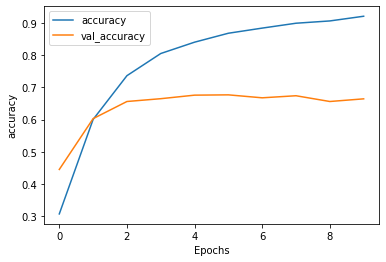

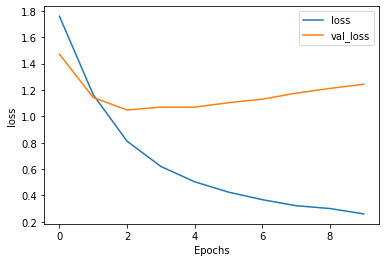

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
text = ["ada pria menggoda saya"]

tokenized_text = tokenizer.texts_to_sequences(text)

In [ ]:
prediction = model.predict(tokenized_text)

In [ ]:
labels = ["Eksploitasi", "Eksploitasi Seksual", "Kekerasan Fisik", "Kekerasan Lainnya", "Kekerasan Psikis", "Kekerasan Seksual", "Penelantaran"]
predicted = prediction.argmax(axis=1)
predict_labels = [labels[predict] for predict in predicted]
print(prediction)
print(predict_labels)

In [ ]:
#Exporting the Model (TFLITE)
export_dir = 'saved_model_laporan/1'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
import pathlib

tflite_model_laporan_file = pathlib.Path('/content/modellaporan.tflite')
tflite_model_laporan_file.write_bytes(tflite_model)

In [ ]:
from google.colab import files
files.download(tflite_model_laporan_file)

In [ ]:
#Exporting the Tokenized Word
import json

with open( 'word_dict_laporan.json' , 'w' ) as file:
    json.dump( tokenizer.word_index , file )